In [1134]:
# !pip install xlrd
# !pip install thefuzz
# !pip install geopandas
# !pip install geodatasets

In [1135]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# import geopandas as gpd
# import geodatasets as gds

from thefuzz import fuzz
from thefuzz import process
import re

# url = r"C:\Users\PapaYaga\Documents\GitHub\Projects\GSAF5.xls"
url = r"GSAF5.xls"
sharks_df = pd.DataFrame(pd.read_excel(url))

def clean_cols(col):
    """
    Takes a Series as argument, strips it off its whitespaces and capitalizes it.
    """
    col = col.strip()
    col = col.title()
    return col

def fix_m(n):
    """
    Takes a three-value long string and transforms it into an appropriate month number.
    """
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    n = process.extractOne(n, months, scorer=fuzz.partial_ratio)[0]
    m_numbers = {months[x]:("0"+str(x+1) if x<9 else str(x+1)) for x in range(12)}
    for m in m_numbers:
        if n == m:
            n = m_numbers[m]
    return n

def clean_date(date):
    """
    Takes a Series as argument, cleans it.
    """
    check = re.findall("\d\d.\D\D{3}\d{4}|\d\d.\D\D{3}|\d{4}", str(date))
    if check:
        try:
            check = check[0].replace(" ","-")
            month = re.findall("[a-zA-Z]{3}",str(check))[0]
            month_new = fix_m(month)
            check = check.replace(month, str(month_new))
            check = f"{check[:2]}-{check[3:5]}-{check[6:]}"
        except IndexError:
            if check == "1018":
                check = "2018"
            elif check >= "2024":
                check = "1959"
            return str(check)
        else:
            return str(check)
    else:
        return ""

def clean_type(type):
    """

    """
    type_dict = {"Unprovoked":"Unprovoked",
             "Provoked":"Provoked",
             "Invalid":"Invalid",
             "Watercraft":"Watercraft",
             "Sea Disaster":"Sea_Disaster",
             "Questionable":"Invalid",
             "Boat":"Watercraft",
             " Provoked":"Provoked",
             "?":"Invalid",
             "Unconfirmed":"Invalid",
             "Unverified":"Invalid",
             "Under investigation":"Invalid",}
    return type.map(type_dict)

def clean_ctr(ctr):
    """
    
    """
    ctr = str(ctr).title().strip()
    ctr = ctr.replace("?","").replace("(Uae)","").replace("St ","St. ")
    if ctr == "Iran / Iraq":
        ctr = "Iran"
    elif ctr == "Ceylon (Sri Lanka)":
        ctr = "Sri Lanka"
    return ctr
    
def extract_m(m):
    """
    
    """
    m = m.map(lambda x: re.findall("-..-",str(x))[0].replace("-","") if len(str(x))>4 else x)
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    m_num2 = {"0"+str(x+1):months[x] for x in range(12)}
    return m.map(m_num2)

In [1136]:
def normalise_sex(df):
    sex_mapping = {
    'M': 'M',
    'F': 'F', 
    ' M': 'M',
    'M ': 'M',
    'lli': 'M',
    'M x 2': 'M',
    '.': 'U',
    }

    df["Sex"] = df["Sex"].map(sex_mapping)
    df["Sex"] = df["Sex"].map(sex_mapping).fillna('U')
    return df

def get_activity(activity):
    if activity == 'Undisclosed':
        return 'Undisclosed'

    activity = activity.lower()

    for i in diving_activites:
        if fuzz.partial_ratio(i.lower(), activity) > 75:
            return 'Diving'
            
    for i in boating_activities:
        if fuzz.partial_ratio(i.lower(), activity) > 75:
            return 'Boating'

    for i in swimming_and_bathing_activities:
        if fuzz.partial_ratio(i.lower(), activity) > 75:
            return 'Swimming/Bathing'

    for i in surfing_activities:
        if fuzz.partial_ratio(i.lower(), activity) > 75:
            return 'Surfing'

    for i in fishing_activities:
        if fuzz.partial_ratio(i.lower(), activity) > 75:
            return 'Fishing'
    
    return 'Not categorised'

def get_species(x):
    x = x.lower()
    for species, variations in species_list:
        species = species.lower()
        for variation in variations:
            if fuzz.partial_ratio(variation.lower(), x) > 70:
                return species.capitalize()
    return 'Other'

def normalize_injury(df):
    df["Injury"] = df["Injury"].apply(lambda x: "Fatal" if isinstance(x, str) and "fatal" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Severe" if isinstance(x, str) and "bitten" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Severe" if isinstance(x, str) and "broken" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Severe" if isinstance(x, str) and "lost" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Severe" if isinstance(x, str) and "severe" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Moderate" if isinstance(x, str) and "lacerations" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Minor" if isinstance(x, str) and "minor" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Moderate" if isinstance(x, str) and "laceration" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "No injury sustained" if isinstance(x, str) and "no injury" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Unknown" if isinstance(x, str) and "no details" in x.lower() else x)
    df["Injury"] = df["Injury"].apply(lambda x: "Unclassified" if x not in ["Fatal", "Severe", "Moderate", "Minor", "No injury sustained", "Unknown"] else x)
    return df

def classify_size(length):
    try:
        length = float(length)
        if length > 3.0:
            return "Large"
        elif 1.5 <= length <= 3.0:
            return "Medium"
        else:
            return "Small"
    except ValueError:
        return "Unknown"

def get_time(x):
    if x == 'Unknown':
        return x
    
    try:
        x = str(x)  
        x = x.split('h')[0]
        x = int(x)
        
        if x > 23:                 
            x = int(x / 100)
        
        time_ranges = {
            'Morning': (6, 11),    # '06:00', '11:59'
            'Afternoon': (12, 17), # '12:00', '17:59'
            'Evening': (18, 21),   # '18:00', '21:59'
        }
     
        for t_range, (start, end) in time_ranges.items():
            if start <= x <= end:
                return t_range
        
        if (22 <= x <= 24) | (0 <= x <= 5):
            return 'Night'
        
        return None

    except:
        time_ranges = ['Morning', 'Afternoon', 'Evening', 'Night']

        for t_range in time_ranges:
            if fuzz.partial_ratio(t_range, x) > 70:
                return t_range
           
        return None


In [1137]:
def name_unknown(df):
    df['Name'] = np.where(df['Name'].isin(['male', 'female']), 'Unknown ' + df['Name'], df['Name'])
    df['Name'] = df['Name'].replace('', 'Unknown').fillna('Unknown')
    return df

In [1138]:
sharks_df.columns = pd.Series(sharks_df.columns).apply(clean_cols)
sharks_df["Date"] = sharks_df["Date"].apply(lambda x: clean_date(x))
# sharks_df["Year"] = sharks_df["Date"].apply(lambda x: re.findall("[0-9]{4}", x)[0] if x else x)
sharks_df["Year"] = sharks_df["Year"].apply(lambda x: str(x).replace(".0",""))
sharks_df["Months"] = sharks_df["Date"]
sharks_df["Months"] = extract_m(sharks_df["Months"])
sharks_df["Date"] = pd.to_datetime(sharks_df["Date"],format="mixed", errors="coerce")
sharks_df.set_index(["Date"], inplace=True, drop=True)

In [1139]:
sharks_df["Type"] = clean_type(sharks_df["Type"])
sharks_df["Country"] = sharks_df["Country"].apply(clean_ctr)
sharks_df["State"] = sharks_df["State"].apply(clean_ctr)

In [1140]:
sharks_rdx = sharks_df[["Year","Type","Country","State","Location","Activity","Name","Sex","Age","Injury","Time","Species","Months"]]
sharks_rdx.dropna(thresh=7, inplace=True)
sharks_rdx.sort_index(ascending=False, inplace=True)
sharks_rdx.drop_duplicates(inplace=True)

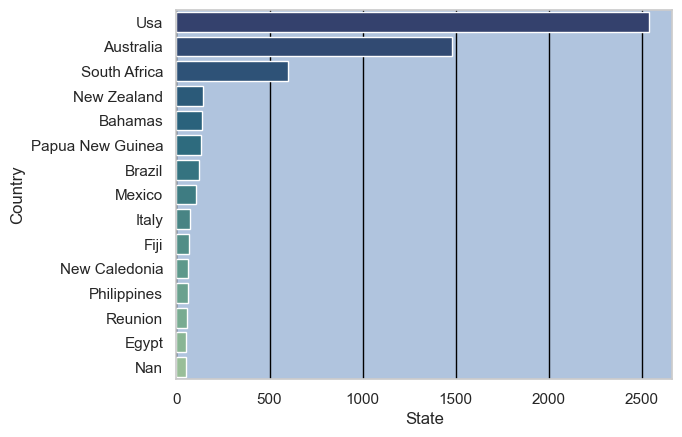

In [1141]:
state_amount = sharks_rdx.groupby(["Country"])["State"].size().sort_values().tail(15)
state_amount_x = sharks_rdx["Country"].value_counts().sort_values().tail(15)

sns.set_style( {"grid.color":"black"}, rc = {'axes.facecolor': 'lightsteelblue'})
sns.barplot(x=state_amount, y=state_amount_x.index, palette="crest").invert_yaxis()

In [ ]:
sns.set_style( {"grid.color":"black"}, rc = {'axes.facecolor': 'lightsteelblue'})


C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


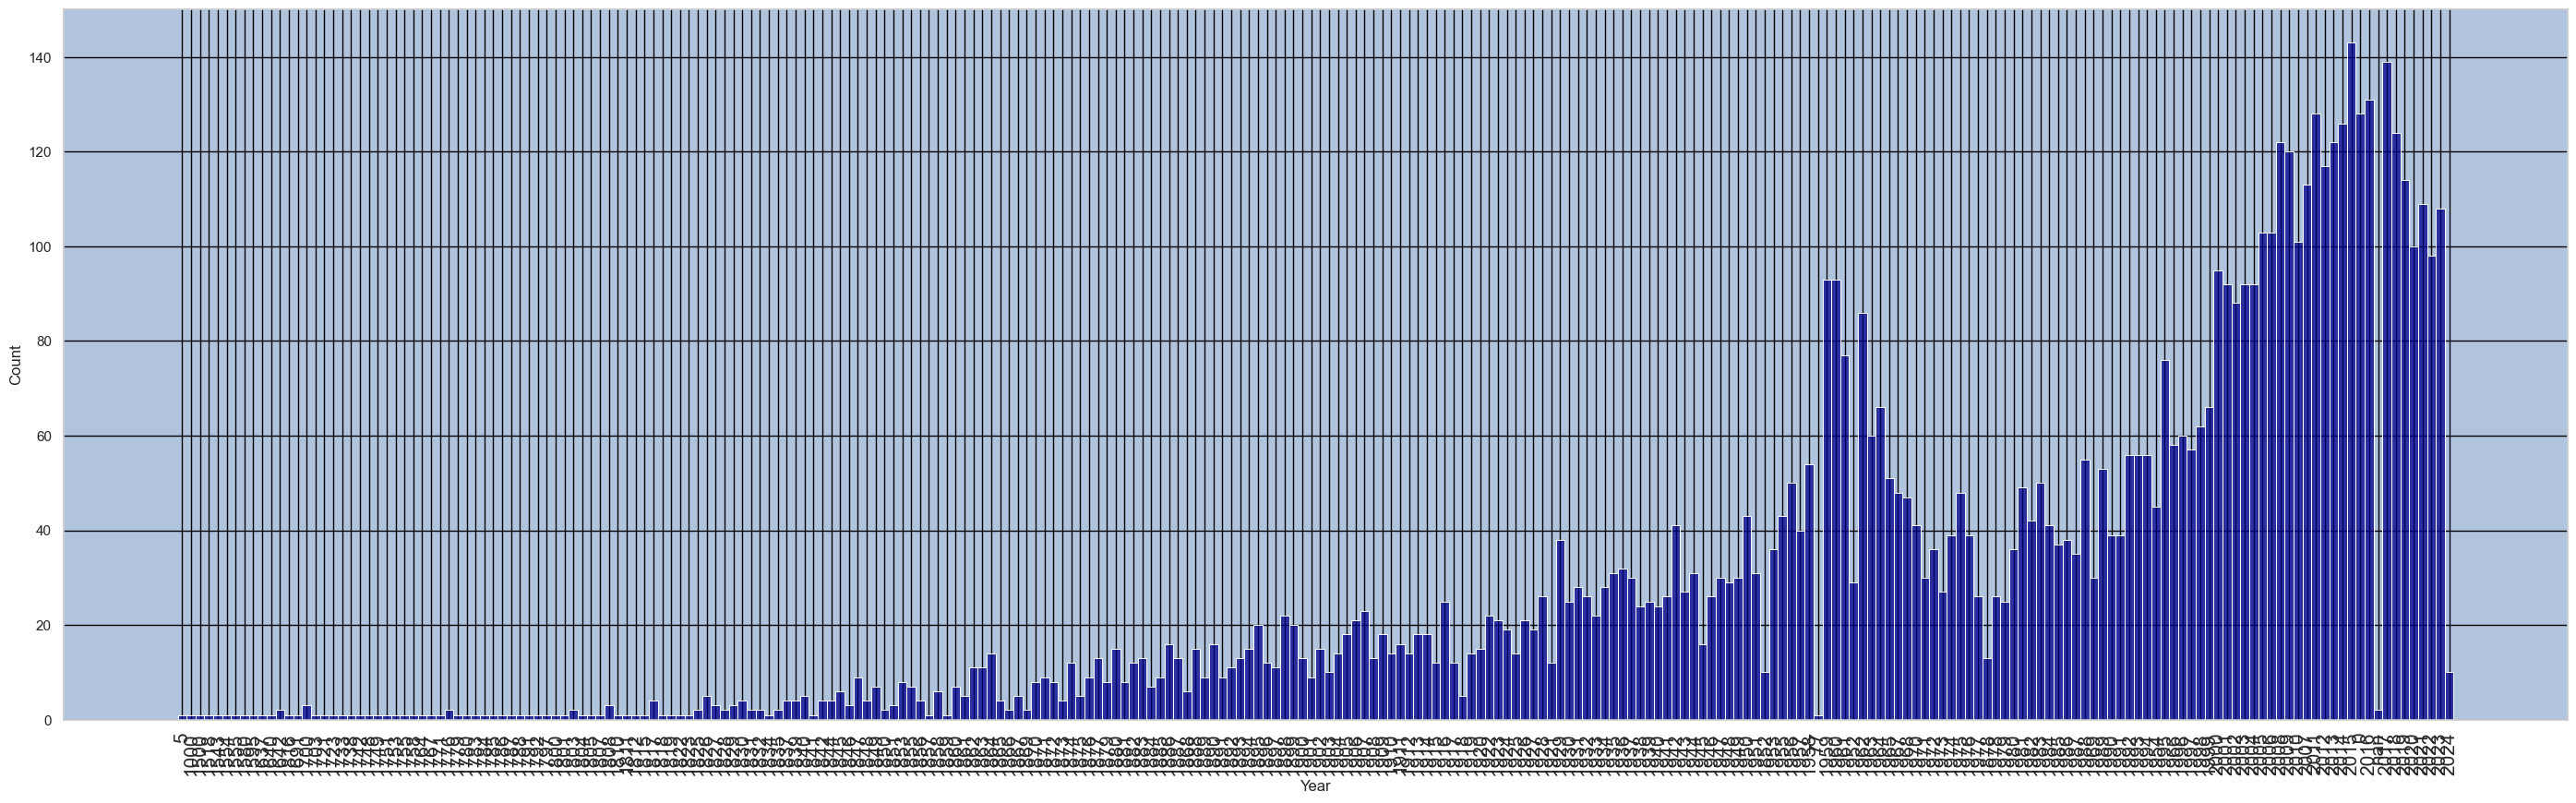

In [1142]:
plt.figure(figsize=(35, 10))
plt.xticks(size = 15, rotation = 90)
sns.histplot(sharks_rdx["Year"], color="darkblue").invert_xaxis()

In [1143]:
# sharks_rdx["Months"] = extract_m(sharks_df["Months"])
sharks_rdx.groupby(["Months"])["Type"].size()

Months
Apr    456
Aug    613
Feb    390
Jan    540
Jul    719
Jun    517
Mar    424
May    413
Sep    573
Name: Type, dtype: int64

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


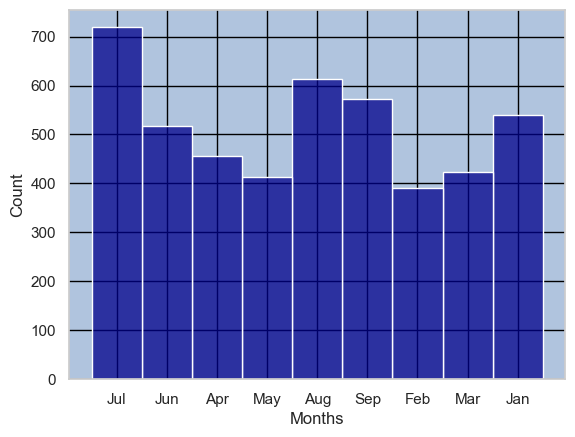

In [1144]:
sns.histplot(sharks_rdx["Months"], color="darkblue").invert_xaxis()
# It is safe to assume that the data is askew due to pure year values being converted into "01-01" format.

In [1145]:
normalise_sex(sharks_rdx)
sharks_rdx["Activity"] = sharks_rdx["Activity"].fillna('Undisclosed')
activities = []

for i in sharks_rdx["Activity"]:
    lst = i.split()
    
    if len(lst) == 1:
        if lst[0].isalpha():          
            activities.append(lst[0])
        
activities = set(activities)

In [1146]:
#Breakdown activities by category
unknown_activities = {
    'Murder',
    'Suicide',
    'UN',
    'Unknown',
    'male',
    'Hilo',
    'Filming',
    'Rescuing',
    'Shipwreck',
    'Shipwrecked',
    'Sightseeing'
}

diving_activites = {
    'Skindiving',
    'Snorkeling',
    'Diving'
}

boating_activities = {
    'Boat',
    'Boating',
    'Canoeing',
    'Kayaking',
    'Paddleboarding',
    'Paddleskiing',
    'Rowing',
    'Sailing',
    'Wakeboarding',
    'Watercraft',
    'Parasailing'
}

swimming_and_bathing_activities = {
    'Bather',
    'Bathing',
    'Sitting',
    'Splashing',
    'Stamding',
    'Standing',
    'Washing',
    'Swimming',
    'Swimmingq',
    'Swmming',
    'Playing',
    'Jumping'
}

surfing_activities = {
    'Bodyboarding',
    'Bodysurfing',
    'Foilboarding',
    'Kiteboarding',
    'Kitesurfing',
    'Skimboarding',
    'Surfing',
    'Windsurfing'
}

fishing_activities = {
    'Angling',
    'Crabbing',
    'Crawling',
    'Crayfishing',
    'Fishing',
    'Fishingat',
    'Lobstering',
    'Oystering',
    'Spearfishing',
    'Spearishing',
    'Shrimping',
    'Batin'
}

In [1147]:
sharks_rdx["Activity"] = sharks_rdx["Activity"].apply(get_activity)

In [1148]:
species_list = []

sharks_rdx["Species"] = sharks_rdx["Species"].fillna('Unknown')

for i in sharks_rdx["Species"]:
    
    if 'shark' in i.lower():
        split = i.lower().split()
        index = 0
        for i in split:
            if 'shark' in i:
                break
            else:
                index += 1
        if split[index -1].isalpha():
            species_list.append(split[index - 1])

In [1149]:
species_list = [
    ("Tiger Shark", ["tiger", "tiger shark", "tigerr"]),
    ("Bull Shark", ["bull"]),
    ("Blacktip Shark", ["blacktip", "blacktip shark", "bluacktip"]),
    ("White Shark", ["white", "whale"]),
    ("Raggedtooth Shark", ["raggedtooth", "sandtiger"]),
    ("Sevengill Shark", ["sevengill"]),
    ("Lemon Shark", ["lemon"]),
    ("Oceanic Whitetip Shark", ["oceanic", "oceanic whitetip", "oceaniic"]),
    ("Nurse Shark", ["nurse"]),
    ("Cookiecutter Shark", ["cookiecutter"]),
    ("Blue Shark", ["blue"]),
    ("Wobbegong Shark", ["wobbegong"]),
    ("Caribbean Reef Shark", ["caribbean", "reef"]),
    ("Grey Nurse Shark", ["grey"]),
    ("Bronze Whaler Shark", ["bronze", "bronz"]),
    ("Mako Shark", ["mako"]),
    ("Spinner Shark", ["spinner"]),
    ("Galapagos Shark", ["galapagos"]),
    ("Tope Shark", ["tope"]),
    ("Epaulette Shark", ["epaulette"]),
    ("Angel Shark", ["angel"]),
    ("Reef Shark", ["reef"]),
    ("Silky Shark", ["silky"]),
    ("Thresher Shark", ["thresher"]),
    ("Hammerhead Shark", ["hammerhead"]),
    ("Shovelnose Shark", ["shovelnose"]),
    ("Tawny Shark", ["tawny"]),
    ("Dogfish Shark", ["dogfish"])
]

In [1150]:
pattern = r'(\d+(?:\.\d+)?)\s*m'

sharks_rdx["Shark Size"] = sharks_rdx["Species"].str.extract(pattern) + 'm'
sharks_rdx["Shark Size"].fillna('Unknown', inplace=True)
sharks_rdx["Species"] = sharks_rdx["Species"].apply(get_species)
sharks_rdx["Shark Size"] = sharks_rdx["Species"].apply(lambda x: get_species(x)[1])
sharks_rdx["Shark Size"] = sharks_rdx["Shark Size"].apply(classify_size)

In [1151]:
sharks_rdx["Time"] = sharks_rdx["Time"].fillna('Unknown')
sharks_rdx["Time"] = sharks_rdx["Time"].apply(get_time)

In [ ]:
normalize_injury(sharks_rdx)

In [ ]:
name_unknown(sharks_rdx)

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Injury', ylabel='Count'>

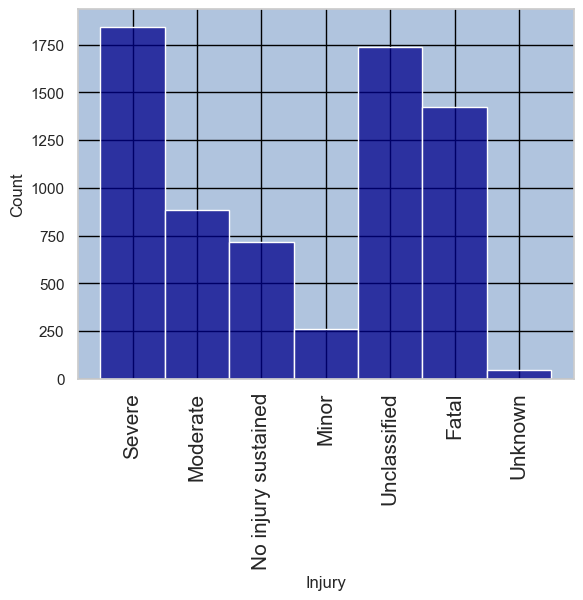

In [1154]:
plt.xticks(size = 15, rotation = 90)
sns.histplot(sharks_rdx["Injury"], color="darkblue")